# Truecolor_3: generating full-disk color composite imagery

In the last colab, [Truecolor_2](https://colab.research.google.com/drive/1W-b5FsmDMecpLNYE5r6y3VMay4udnJu3?authuser=2#scrollTo=0O-cBsHw--mc), we trained a model to predict cloud masks.  In this final colab, we'll stitch together predictions to get full disk images.

# Colab setup

In [1]:
!pip install -U -q dateparser netcdf4 xarray pyresample "google-api-core>=1.11" "google-cloud-core>=1" "google-cloud-storage>=1.16" scikit-image tensorflow

from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

import sys
sys.path.append('/content/gdrive/My Drive/ColabNotebooks/Public/goes_truecolor')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [24]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from typing import Any, Callable, Dict, List, Optional, Text, Tuple, Union

import collections
from contextlib import contextmanager
import datetime
import dateutil.tz
import itertools
import matplotlib.pyplot as plt
import netCDF4  # netCDF4 *must* be imported before tensorflow
import numpy as np
import logging
import os
import pyresample
import re
import skimage 
import skimage.transform
import tempfile
import tensorflow as tf
from tensorflow import keras
import time
import urllib
import xarray

import google.cloud.storage as gcs

from goes_truecolor.lib import goes_reader

PROJECT_ID = 'weather-324'
GOES_BUCKET = 'gcp-public-data-goes-16'
TRAIN_PATH = 'gs://weather-datasets/goes_truecolor/examples/train.tfrecord*'
TEST_PATH = 'gs://weather-datasets/goes_truecolor/examples/test.tfrecord*'
BLUE_MARBLE = 'https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73909/world.topo.bathy.200412.3x5400x2700.jpg'

reader = goes_reader.GoesReader(
    project_id=PROJECT_ID,
    goes_bucket_name=GOES_BUCKET,
    shape=(1024, 1024),
    cache=True)

# Load the trained model

In [0]:
def default_hparams(**kwargs: Any) -> tf.contrib.training.HParams:
  """Create default hyper-parameters for training a model.

  Args:
    **kwargs: default hyper-parameter values to override.

  Returns:
    HParams object with all hyperparameter values.
  """
  hparams = tf.contrib.training.HParams(
      model_dir='gs://weather-datasets/model',
      train_data_path=TRAIN_PATH,
      eval_data_path=TEST_PATH,
      train_batch_size=32,
      learning_rate=1e-3,
      train_steps=10000,
      num_eval_records=128,
      num_cores=8,
      tile_size=64,
      
      # CNN
      kernel_size=5,
      num_filters=16,
      num_layers=3,
  )
  hparams.override_from_dict(kwargs)
  return hparams

hparams = default_hparams()

In [6]:
def load_model(hparams: tf.contrib.training.HParams) -> keras.Model:
  dirnames = tf.gfile.Glob(os.path.join(hparams.model_dir, 'export/exporter/[0-9]*'))
  model_file = sorted(dirnames)[-1]
  tf.logging.info('Loading model from %s', model_file)
  model = tf.contrib.saved_model.load_keras_model(model_file)
  model.summary()
  return model

model = load_model(hparams)

INFO:tensorflow:Loading model from gs://weather-datasets/model/export/exporter/1558301458
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 9)         0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 64, 64, 9)         36        
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        3616      
_________________________________________________________________
activation (Activation)      (None, 64, 64, 16)        0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 64, 64, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16

# Apply the model on some example tiles

Before we get started, let's double-check that the model is performing as expected.

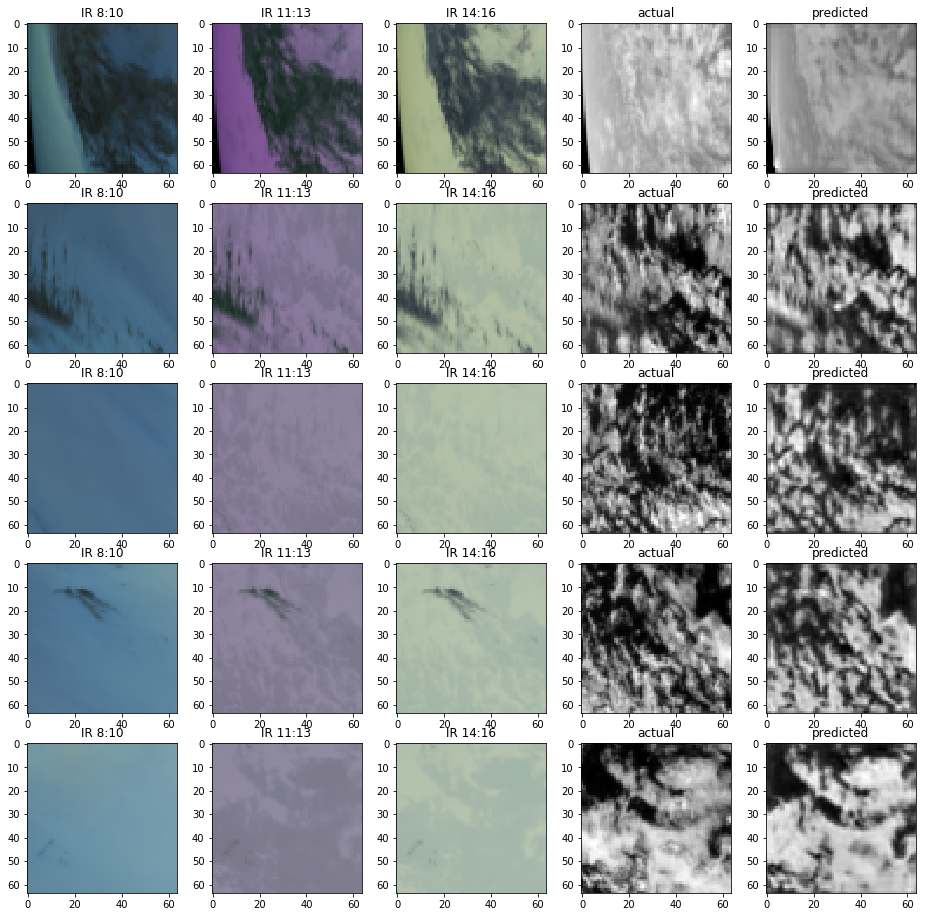

In [7]:
def show_prediction_tiles(t: datetime.datetime, hparams: tf.contrib.training.HParams):
  cloud_mask_img, _ = reader.cloud_mask(t)
  h, w = cloud_mask_img.shape
  tile_size = hparams.tile_size
  raster_out_img = np.split(cloud_mask_img[512:512 + tile_size, :], w // tile_size, axis=1)
  raster_out_img = np.array(raster_out_img)
  
  img, _ = reader.raw_image(t, goes_reader.IR_CHANNELS)
  img = img.astype(np.float32) / 256

  raster_in_img = np.split(img[512:512 + tile_size, :, :], w // tile_size, axis=1)
  raster_in_img = np.array(raster_in_img)
  predict_out_img = model.predict(raster_in_img)
  
  plt.figure(figsize=(16, 16))
  for i in range(5):
    for j in range(3):
      ax = plt.subplot(5, 5, i * 5 + j + 1)
      ax.imshow(raster_in_img[i, :, :, j*3:(j+1)*3])
      plt.title('IR {}:{}'.format(j*3 + 8, j*3 + 10))
    ax = plt.subplot(5, 5, i * 5 + 4)
    ax.imshow(raster_out_img[i, :, :], cmap='gray')
    plt.title('actual')
    ax = plt.subplot(5, 5, i * 5 + 5)
    ax.imshow(predict_out_img[i, :, :, 0], cmap='gray')
    plt.title('predicted')
  plt.show()
    
show_prediction_tiles(datetime.datetime(2019, 1, 1, 17), hparams)

# Full disk cloud mask prediction (no tile overlaps)

To predict the cloud mask for a full disk, we can split the image into tiles, and the apply the model to each of the tiles, concatenating them to produce the full image.

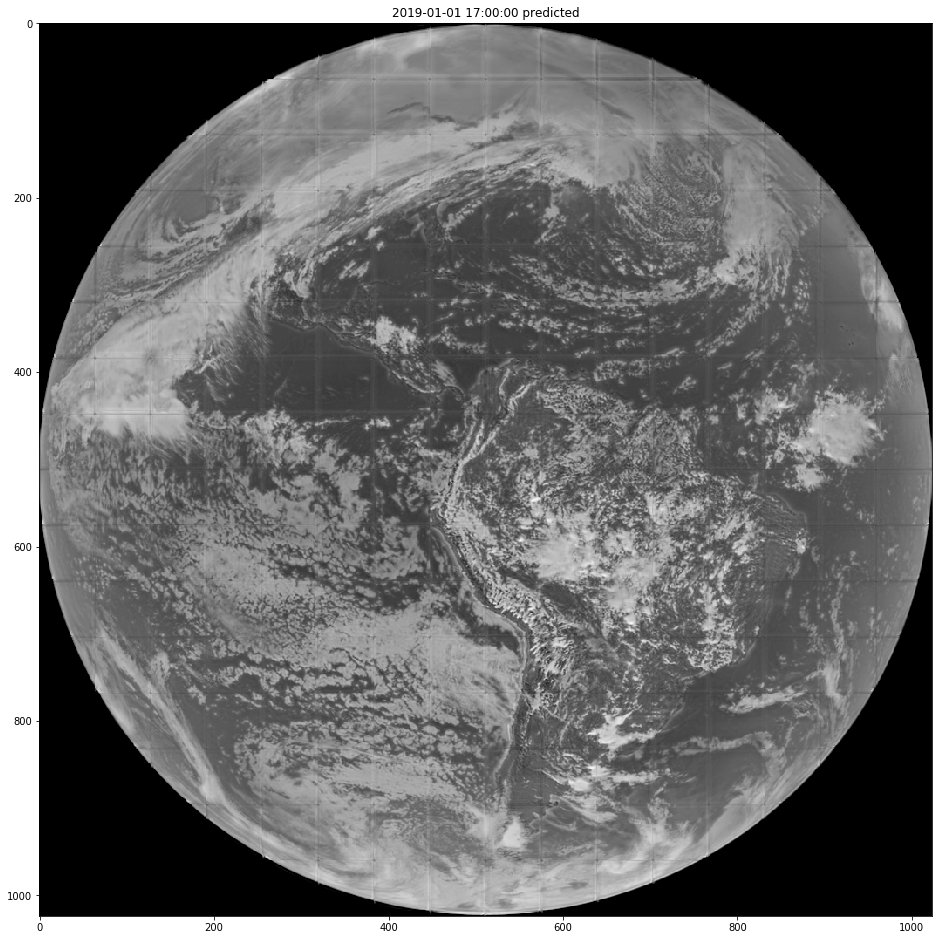

In [19]:
def get_tiles(img: np.ndarray, tile_size: int) -> List[List[np.ndarray]]:
  """Split the image into tiles.
  
  Args:
    img: the 2D image to split.
    tile_size: the desired size of each tile.
    
  Returns:
    A list of columns, where each colums is a list of tiles in a row.
  """
  h, w, _ = img.shape
  partitions = h // tile_size
  cols = []
  for img_col in np.split(img, partitions, axis=1):
    cols.append(np.split(img_col, partitions, axis=0))
  return cols  

def predict_tiled_image(t: datetime.datetime, hparams: tf.contrib.training.HParams) -> Tuple[np.ndarray, Dict[Text, Any]]:
  tile_size = hparams.tile_size
  raster_in_img, md = reader.raw_image(t, goes_reader.IR_CHANNELS)
  raster_in_img = raster_in_img.astype(np.float32) / 256
  raster_in_tiles = get_tiles(raster_in_img, tile_size)

  # Assemble the prediction.
  predict_cols = []
  for raster_in_col in raster_in_tiles:
    raster_in_col = np.array(raster_in_col)
    predict_col = model.predict(raster_in_col)    
    b, h, w, c = predict_col.shape
    predict_col = np.reshape(predict_col, (b * h, w, c))
    predict_cols.append(predict_col)
  predict_img = np.concatenate(predict_cols, axis=1)
  predict_img = predict_img[:, :, 0]
  return predict_img, md
  
def show_tiled_image(t: datetime.datetime, hparams: tf.contrib.training.HParams):
  predict_img, _ = predict_tiled_image(t, hparams)  
 
  plt.figure(figsize=(16, 20))
  plt.imshow(predict_img, cmap='gray')
  plt.title('{} predicted'.format(t))
  plt.show()
    
show_tiled_image(datetime.datetime(2019, 1, 1, 17), hparams)

# Removing pad effects

The tiling is straightforward, but we can see artifacts in the output due to the tiling.  The problem is that the CNN has border effects to edge padding with zeros.  We can use a different padding method, but an easy way to account for the problem is to trim the border of each of the predictions.

Let's trim a border of width 8 pixels from each of the tiles. For a prediction of size 64x64, we'll use only the inner 48x48 values.

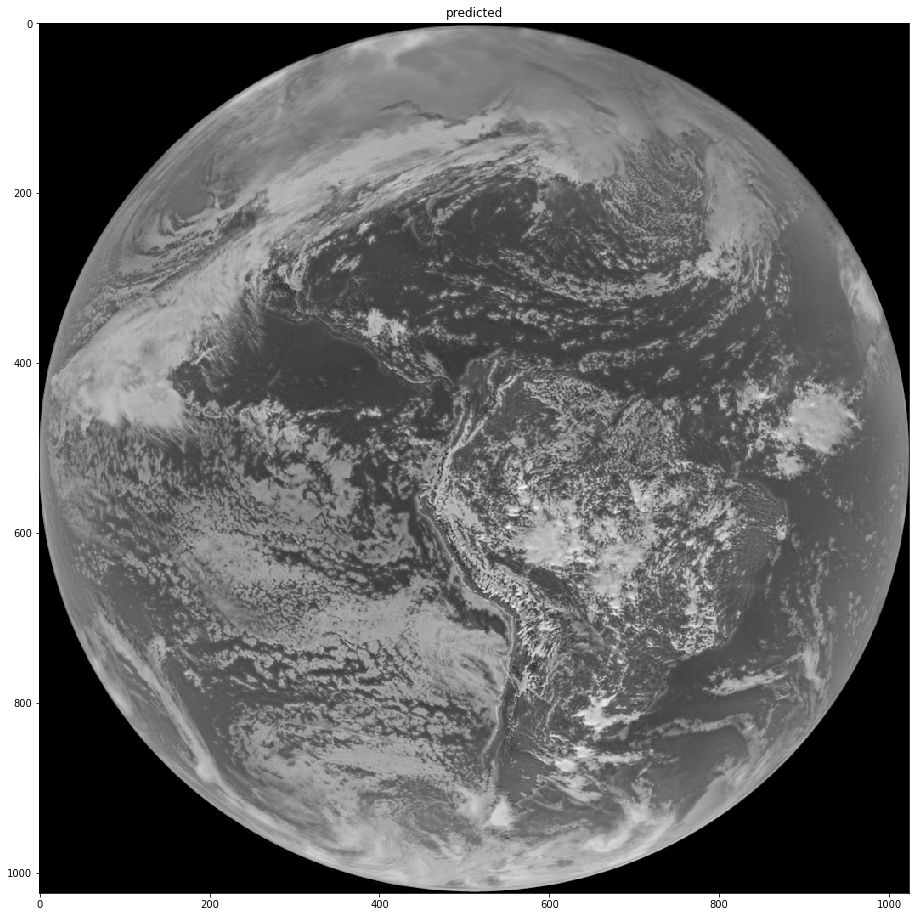

In [22]:
TILE_BORDER = 8

def _get_overlapping_tiles(
    img: np.ndarray, tile_size: int, tile_border_size: int) -> List[List[np.ndarray]]:
  """Split an image into tiles.

  Args:
    img: the image, of shape (height, width, channels).
    tile_size: the size of square
    tile_border_size: a border around each tile

  Returns:
    A list of columns, each of which is a row of tiles.
  """
  h, _, _ = img.shape
  inner_tile_size = tile_size - 2 * tile_border_size
  num_tiles = (h + inner_tile_size - 1) // inner_tile_size
  new_h = num_tiles * inner_tile_size + 2 * tile_border_size
  pad_l = tile_border_size
  pad_r = new_h - tile_border_size - h
  img = np.pad(img, ((pad_l, pad_r), (pad_l, pad_r), (0, 0)), 'constant')
  cols = []
  for x in range(0, new_h - tile_size + 1, inner_tile_size):
    rows = []
    for y in range(0, new_h - tile_size + 1, inner_tile_size):
      rows.append(img[y:y+tile_size, x:x+tile_size, :])
    cols.append(rows)
  return cols

def predict_overlapping_image(t: datetime.datetime, hparams: tf.contrib.training.HParams) -> Tuple[np.ndarray, Dict[Text, Any]]:
  tile_size = hparams.tile_size
  raster_in_img, md = reader.raw_image(t, goes_reader.IR_CHANNELS)
  raster_in_img = raster_in_img.astype(np.float32) / 256
  h, w, _ = raster_in_img.shape
  raster_in_tiles = _get_overlapping_tiles(raster_in_img, tile_size, TILE_BORDER)

  # Assemble the prediction.
  predict_cols = []
  for raster_in_col in raster_in_tiles:
    raster_in_col = np.array(raster_in_col)
    predict_col = model.predict(raster_in_col)    
    tiles = [predict_col[b, TILE_BORDER:-TILE_BORDER, TILE_BORDER:-TILE_BORDER, :]
             for b in range(predict_col.shape[0])]    
    predict_col = np.concatenate(tiles, axis=0)
    predict_cols.append(predict_col)
  predict_img = np.concatenate(predict_cols, axis=1)
  predict_img = predict_img[:h, :w, 0]  
  predict_img = (predict_img * 255.9).astype(np.uint8)
  return predict_img, md

def show_overlapping_image(t: datetime.datetime, hparams: tf.contrib.training.HParams):
  raster_out_img, _ = reader.cloud_mask(t)
  predict_img, _ = predict_overlapping_image(t, hparams)
 
  plt.figure(figsize=(16, 16))
  plt.imshow(predict_img, cmap='gray')
  plt.title('predicted')
  plt.show()
    
show_overlapping_image(datetime.datetime(2019, 1, 1, 17), hparams)

# Composite image

The "overlapping" method gives significantly better results.  Let's overlay this onto the world image.

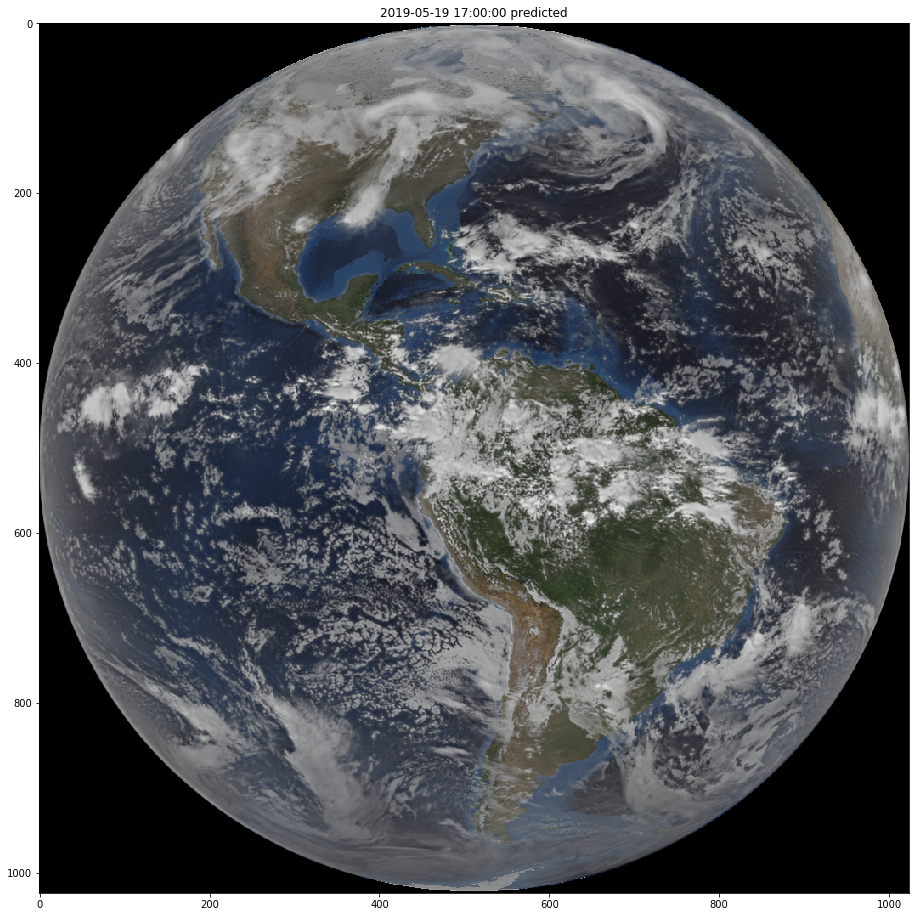

In [25]:
def show_world_image(t: datetime.datetime, hparams: tf.contrib.training.HParams):
  predict_img, md = predict_overlapping_image(t, hparams)
  world_map = reader.load_world_img_from_url(BLUE_MARBLE, md)
  world_map = world_map.astype(np.float32) / 255
 
  plt.figure(figsize=(16, 16))
  predict_img = predict_img[:, :, np.newaxis]
  predict_mask = 1 / (1 + np.exp(-10 * (predict_img - 0.3)))
  predict_img = predict_img * predict_mask + (1 - predict_mask) * world_map
  plt.imshow(predict_img, cmap='gray')
  plt.title('{} predicted'.format(t))
  plt.show()
    
show_world_image(datetime.datetime(2019, 5, 19, 17), hparams)

# 24 hour sequence

To finish it off, let's generate a 24 hour image sequence.

In [27]:
def show_daily_images(t: datetime.datetime, hparams: tf.contrib.training.HParams):
  plt.figure(figsize=(20, 32))
  for i in range(6):
    for j in range(4):
      h = i * 4 + j
      new_t = t + datetime.timedelta(hours=h)
      predict_img, md = predict_overlapping_image(new_t, hparams)
      world_map = reader.load_world_img_from_url(BLUE_MARBLE, md)
      world_map = world_map.astype(np.float32) / 255
      predict_img = np.maximum(0, np.minimum(1, predict_img))
      predict_img = predict_img[:, :, np.newaxis]
      predict_mask = 1 / (1 + np.exp(-10 * (predict_img - 0.3)))
      predict_img = predict_img * predict_mask + (1 - predict_mask) * world_map
      ax = plt.subplot(6, 4, h + 1)
      ax.imshow(predict_img)
      plt.title(str(new_t))
  plt.show()
    
show_daily_images(datetime.datetime(2019, 1, 1), hparams)

Output hidden; open in https://colab.research.google.com to view.